# Проект "Телекоммуникации"


Оператор связи «Ниединогоразрыва.ком» хочет научиться прогнозировать отток клиентов. Если выяснится, что пользователь планирует уйти, ему будут предложены промокоды и специальные условия. Команда оператора собрала персональные данные о некоторых клиентах, информацию об их тарифах и договорах.

Оператор предоставляет два основных типа услуг: 

- Стационарную телефонную связь. Возможно подключение телефонного аппарата к нескольким линиям одновременно.
- Интернет. Подключение может быть двух типов: через телефонную линию (DSL, от англ. digital subscriber line, «цифровая абонентская линия») или оптоволоконный кабель (Fiber optic).

Также доступны такие услуги:

- Интернет-безопасность: антивирус (DeviceProtection) и блокировка небезопасных сайтов (OnlineSecurity);
- Выделенная линия технической поддержки (TechSupport);
- Облачное хранилище файлов для резервного копирования данных (OnlineBackup);
- Стриминговое телевидение (StreamingTV) и каталог фильмов (StreamingMovies).

За услуги клиенты могут платить каждый месяц или заключить договор на 1–2 года. Доступны различные способы расчёта и возможность получения электронного чека.

### Описание данных

Данные состоят из файлов, полученных из разных источников:

- `contract_new.csv` — информация о договоре;
- `personal_new.csv` — персональные данные клиента;
- `internet_new.csv` — информация об интернет-услугах;
- `phone_new.csv` — информация об услугах телефонии.

Во всех файлах столбец customerID содержит код клиента.
Информация о договорах актуальна на 1 февраля 2020.

**Цель проекта:**

Спрогнозировать отток клиентов для оператора связи "Ниединогоразрыва.ком". Для этого необходимо провести анализ данных, определить факторы, которые влияют на отток клиентов, и построить модель прогнозирования, ROC-AUC которой должна быть не менее 0,85


### План проекта

**Исследовательский аназиз данных:**

В данном разделе проекта необходимо рассмотреть предоставленную информацию. Общую информацию о датасетах, проверить типы данных, наличие пропусков. Рассмотреть, какие новые признаки необходимо добавить, нужно ли объединять датасеты.

**Обучение модели:**

В данном разделе необходимо разделить данные на выборки, определить признаки и целевой признак, произвести кодирование и масштабирование данных. Далее для каждой модели нужно подобрать гиперпараметры, для лучшего значения качества на метрике roc auc. После определения лучшей модели, её необходимо проверить на тестовой выборке. Сформулировать выводы и рекомендации.



In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import timedelta
from sklearn.preprocessing import StandardScaler
import catboost as cat
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score, confusion_matrix, roc_curve, roc_auc_score, auc, ConfusionMatrixDisplay
from sklearn.ensemble import RandomForestClassifier
from sklearn import linear_model
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import lightgbm as lgb
from sklearn.dummy import DummyClassifier
from sklearn.preprocessing import OrdinalEncoder 
from sklearn.inspection import permutation_importance
from sklearn import svm
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from catboost import CatBoostClassifier
from sklearn.pipeline import Pipeline
from datetime import datetime
from scipy import stats as st
from sklearn. preprocessing import OneHotEncoder
import phik
from phik.report import plot_correlation_matrix
from phik import report


import warnings
warnings.filterwarnings("ignore")

In [2]:
try:
    data_contract = pd.read_csv('C:/Users/klimatutti/Downloads/contract_new.csv')
    data_personal = pd.read_csv('C:/Users/klimatutti/Downloads/personal_new.csv')
    data_internet = pd.read_csv('C:/Users/klimatutti/Downloads/internet_new.csv')
    data_phone = pd.read_csv('C:/Users/klimatutti/Downloads/phone_new.csv')
except:
    data_contract = pd.read_csv('/datasets/contract_new.csv')
    data_personal = pd.read_csv('/datasets/personal_new.csv')
    data_internet = pd.read_csv('/datasets/internet_new.csv')
    data_phone = pd.read_csv('/datasets/phone_new.csv')

In [3]:
data_contract.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
dtypes: float64(1), object(7)
memory usage: 440.3+ KB


In [4]:
data_contract.head()

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,31.04
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,2071.84
2,3668-QPYBK,2019-10-01,No,Month-to-month,Yes,Mailed check,53.85,226.17
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1960.6
4,9237-HQITU,2019-09-01,No,Month-to-month,Yes,Electronic check,70.70,353.5


Информация о договорах клиентов дана без пропусков. Видны неверные типы данных у столбцов `BeginDate`, `EndDate` и `TotalCharges`.

Немного приведём названия столбцов в правильный вид.

In [5]:
data_contract.columns = data_contract.columns.str.replace(r"([A-Z])", r" \1").str.lower().str.replace(' ', '_').str[1:]

In [6]:
data_contract.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   ustomer_i_d        7043 non-null   object 
 1   begin_date         7043 non-null   object 
 2   end_date           7043 non-null   object 
 3   type               7043 non-null   object 
 4   paperless_billing  7043 non-null   object 
 5   payment_method     7043 non-null   object 
 6   monthly_charges    7043 non-null   float64
 7   total_charges      7043 non-null   object 
dtypes: float64(1), object(7)
memory usage: 440.3+ KB


Изменим типы данных

In [7]:
data_contract['total_charges'] = pd.to_numeric(data_contract['total_charges'], errors='coerce')
data_contract['begin_date'] = pd.to_datetime(data_contract['begin_date'], format='%Y-%m-%d %H:%M:%S')

In [8]:
data_contract.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   ustomer_i_d        7043 non-null   object        
 1   begin_date         7043 non-null   datetime64[ns]
 2   end_date           7043 non-null   object        
 3   type               7043 non-null   object        
 4   paperless_billing  7043 non-null   object        
 5   payment_method     7043 non-null   object        
 6   monthly_charges    7043 non-null   float64       
 7   total_charges      7032 non-null   float64       
dtypes: datetime64[ns](1), float64(2), object(5)
memory usage: 440.3+ KB


Рассмотрим следующие данные о клиентах

In [9]:
data_personal.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   int64 
 3   Partner        7043 non-null   object
 4   Dependents     7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB


In [10]:
data_personal.head()

,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No


Пропущенных значений в данных также нет.

Изменим названия столбцов.

In [11]:
data_personal.columns = data_personal.columns.str.replace(r"([A-Z])", r" \1").str.lower().str.replace(' ', '_').str[1:]

In [12]:
data_personal.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   ustomer_i_d     7043 non-null   object
 1   ender           7043 non-null   object
 2   senior_citizen  7043 non-null   int64 
 3   partner         7043 non-null   object
 4   dependents      7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB


Следующий датасет с информацией об услугах интернета.

In [13]:
data_internet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        5517 non-null   object
 1   InternetService   5517 non-null   object
 2   OnlineSecurity    5517 non-null   object
 3   OnlineBackup      5517 non-null   object
 4   DeviceProtection  5517 non-null   object
 5   TechSupport       5517 non-null   object
 6   StreamingTV       5517 non-null   object
 7   StreamingMovies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB


Значений меньше, чем в предыдущих датасетах, но пропусков также нет. 

In [14]:
data_internet.columns = data_internet.columns.str.replace(r"([A-Z])", r" \1").str.lower().str.replace(' ', '_').str[1:]

In [15]:
data_internet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   ustomer_i_d        5517 non-null   object
 1   internet_service   5517 non-null   object
 2   online_security    5517 non-null   object
 3   online_backup      5517 non-null   object
 4   device_protection  5517 non-null   object
 5   tech_support       5517 non-null   object
 6   streaming_t_v      5517 non-null   object
 7   streaming_movies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB


И последний датасет с информацией о телефонных услугах.

In [16]:
data_phone.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     6361 non-null   object
 1   MultipleLines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB


Пропусков нет

In [17]:
data_phone.columns = data_phone.columns.str.replace(r"([A-Z])", r" \1").str.lower().str.replace(' ', '_').str[1:]

In [18]:
tables = {'contract': data_contract, 'personal': data_personal, 'internet': data_internet, 'phone': data_phone}

In [19]:
for a, b in tables.items():
    print(f'Информация о таблице {a}')
    display(b.describe(include='all').T)
    print()

Информация о таблице contract


,count,unique,top,freq,first,last,mean,std,min,25%,50%,75%,max
ustomer_i_d,7043,7043,7590-VHVEG,1,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN
begin_date,7043,77,2014-02-01 00:00:00,366,2013-10-01,2020-02-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN
end_date,7043,67,No,5942,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN
type,7043,3,Month-to-month,3875,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN
paperless_billing,7043,2,Yes,4171,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN
payment_method,7043,4,Electronic check,2365,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN
monthly_charges,7043.0,NaN,NaN,NaN,NaT,NaT,64.761692,30.090047,18.25,35.5,70.35,89.85,118.75
total_charges,7032.0,NaN,NaN,NaN,NaT,NaT,2118.621822,2112.736199,19.05,439.745,1345.275,3239.3175,9221.38



Информация о таблице personal


,count,unique,top,freq,mean,std,min,25%,50%,75%,max
ustomer_i_d,7043,7043,7590-VHVEG,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ender,7043,2,Male,3555,NaN,NaN,NaN,NaN,NaN,NaN,NaN
senior_citizen,7043.0,NaN,NaN,NaN,0.162147,0.368612,0.0,0.0,0.0,0.0,1.0
partner,7043,2,No,3641,NaN,NaN,NaN,NaN,NaN,NaN,NaN
dependents,7043,2,No,4933,NaN,NaN,NaN,NaN,NaN,NaN,NaN



Информация о таблице internet


,count,unique,top,freq
ustomer_i_d,5517,5517,7590-VHVEG,1
internet_service,5517,2,Fiber optic,3096
online_security,5517,2,No,3498
online_backup,5517,2,No,3088
device_protection,5517,2,No,3095
tech_support,5517,2,No,3473
streaming_t_v,5517,2,No,2810
streaming_movies,5517,2,No,2785



Информация о таблице phone


,count,unique,top,freq
ustomer_i_d,6361,6361,5575-GNVDE,1
multiple_lines,6361,2,No,3390


**Таблица data_contract:**

- 7043 пользователя;
- 77 уникальных дат заключения контрактов и 5 уникальных завершений контрактов;
- Всего 3 уникальных типов оплаты, наиболее часто встречающийся тип Month-to-month - 3875 из 7043;
- paperless_billing - содержит два значения Yes, No. В 60% случаев встречается yes;
- monthly_charges. В среднем, ежемесячный платеж для пользователя - 64,8.


**Таблица data_personal:**

Информация в таблице есть о всех 7043 пользователях, заключавших когда-либо контракт

**Таблица data_internet:**

- Пользуются интернетом 5517 пользователей из 7043
- Есть два типа интернета, чаще встречается оптоволокно (56%)

**Таблица data_phone:**

- 6361 пользователь из 7043 пользуются данной услугой.
- Существует два типа линии - одна или несколько. 

Так как только в таблице `data_contract` достаточное количество числовых признаков, рассмотрим гистограмму распределения.

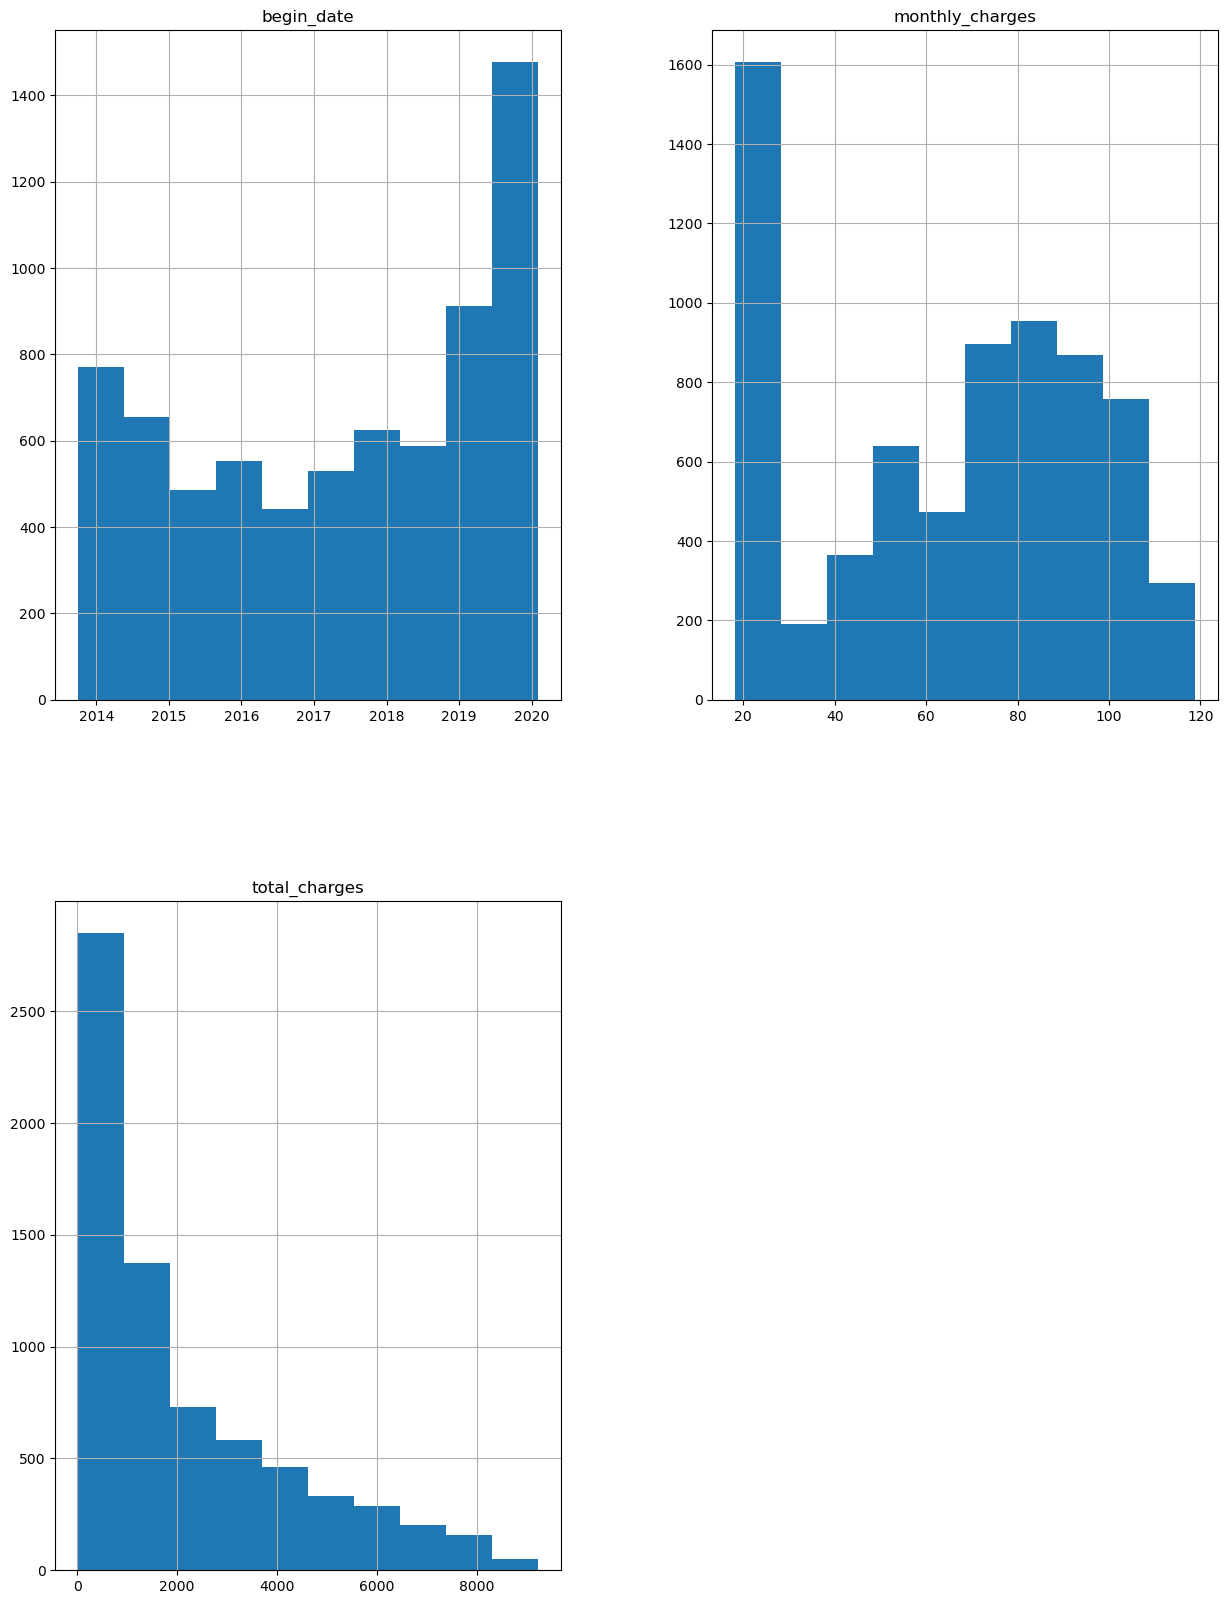

In [20]:
data_contract.hist(figsize=(15, 20));

Больше всего договоров было заключено в 2020 году. В столбцах с тратами всё просто - чем больше сумма, тем меньше количество таких пользователей.

<div class="alert alert-success">
<b>👍 Успех:</b> Все верно!
</div>

Для последующей обработки данных объединим датасеты по полю id

In [21]:
data = pd.merge(data_contract, data_personal, how='left') 
data = pd.merge(data, data_internet, how='left')
data = pd.merge(data, data_phone, how='left')

In [22]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   ustomer_i_d        7043 non-null   object        
 1   begin_date         7043 non-null   datetime64[ns]
 2   end_date           7043 non-null   object        
 3   type               7043 non-null   object        
 4   paperless_billing  7043 non-null   object        
 5   payment_method     7043 non-null   object        
 6   monthly_charges    7043 non-null   float64       
 7   total_charges      7032 non-null   float64       
 8   ender              7043 non-null   object        
 9   senior_citizen     7043 non-null   int64         
 10  partner            7043 non-null   object        
 11  dependents         7043 non-null   object        
 12  internet_service   5517 non-null   object        
 13  online_security    5517 non-null   object        
 14  online_b

Так как не во всех дата сетах количетсво строк было одним, после объединения появились пропуски.

Начнём рассматривать пропущенные значения

In [23]:
data.isna().sum()

ustomer_i_d             0
begin_date              0
end_date                0
type                    0
paperless_billing       0
payment_method          0
monthly_charges         0
total_charges          11
ender                   0
senior_citizen          0
partner                 0
dependents              0
internet_service     1526
online_security      1526
online_backup        1526
device_protection    1526
tech_support         1526
streaming_t_v        1526
streaming_movies     1526
multiple_lines        682
dtype: int64

In [24]:
data.loc[data['total_charges'].isna()]

,ustomer_i_d,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,ender,senior_citizen,partner,dependents,internet_service,online_security,online_backup,device_protection,tech_support,streaming_t_v,streaming_movies,multiple_lines
488,4472-LVYGI,2020-02-01,No,Two year,Yes,Bank transfer (automatic),52.55,NaN,Female,0,Yes,Yes,DSL,Yes,No,Yes,Yes,Yes,No,NaN
753,3115-CZMZD,2020-02-01,No,Two year,No,Mailed check,20.25,NaN,Male,0,No,Yes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No
936,5709-LVOEQ,2020-02-01,No,Two year,No,Mailed check,80.85,NaN,Female,0,Yes,Yes,DSL,Yes,Yes,Yes,No,Yes,Yes,No
1082,4367-NUYAO,2020-02-01,No,Two year,No,Mailed check,25.75,NaN,Male,0,Yes,Yes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Yes
1340,1371-DWPAZ,2020-02-01,No,Two year,No,Credit card (automatic),56.05,NaN,Female,0,Yes,Yes,DSL,Yes,Yes,Yes,Yes,Yes,No,NaN
3331,7644-OMVMY,2020-02-01,No,Two year,No,Mailed check,19.85,NaN,Male,0,Yes,Yes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No
3826,3213-VVOLG,2020-02-01,No,Two year,No,Mailed check,25.35,NaN,Male,0,Yes,Yes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Yes
4380,2520-SGTTA,2020-02-01,No,Two year,No,Mailed check,20.00,NaN,Female,0,Yes,Yes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No
5218,2923-ARZLG,2020-02-01,No,One year,Yes,Mailed check,19.70,NaN,Male,0,Yes,Yes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No
6670,4075-WKNIU,2020-02-01,No,Two year,No,Mailed check,73.35,NaN,Female,0,Yes,Yes,DSL,No,Yes,Yes,Yes,Yes,No,Yes


In [25]:
data.describe()

,monthly_charges,total_charges,senior_citizen
count,7043.000000,7032.000000,7043.000000
mean,64.761692,2118.621822,0.162147
std,30.090047,2112.736199,0.368612
min,18.250000,19.050000,0.000000
25%,35.500000,439.745000,0.000000
50%,70.350000,1345.275000,0.000000
75%,89.850000,3239.317500,0.000000
max,118.750000,9221.380000,1.000000


In [26]:
print('Количество пользователей с одинаковым ежемесячным и общим платежем до изменений', 
      data.loc[data['monthly_charges'] == data['total_charges']].shape[0])

Количество пользователей с одинаковым ежемесячным и общим платежем до изменений 124


Все 11 пропусков в `total_charges` есть у записей с датой начала договора - 01.02.2020, то есть дата выгрузки. Это значит, что информации об общих расходах ещё нет, можно заменить пропущенные значение в данном столбце на значения столбца `monthly_charges`

In [27]:
data.loc[data['total_charges'].isna(), 'total_charges'] = data['monthly_charges']

In [28]:
print('Количество пользователей с одинаковым месяынм и общим платежем после изменений', 
      data.loc[data['monthly_charges'] == data['total_charges']].shape[0])

Количество пользователей с одинаковым месяынм и общим платежем после изменений 135


In [29]:
data.describe()

,monthly_charges,total_charges,senior_citizen
count,7043.000000,7043.000000,7043.000000
mean,64.761692,2115.377573,0.162147
std,30.090047,2112.678861,0.368612
min,18.250000,19.050000,0.000000
25%,35.500000,436.750000,0.000000
50%,70.350000,1343.350000,0.000000
75%,89.850000,3236.690000,0.000000
max,118.750000,9221.380000,1.000000


In [30]:
data.isna().sum()

ustomer_i_d             0
begin_date              0
end_date                0
type                    0
paperless_billing       0
payment_method          0
monthly_charges         0
total_charges           0
ender                   0
senior_citizen          0
partner                 0
dependents              0
internet_service     1526
online_security      1526
online_backup        1526
device_protection    1526
tech_support         1526
streaming_t_v        1526
streaming_movies     1526
multiple_lines        682
dtype: int64

Следующий стобцы пользователей интернета заполним заглушкой 'no_internet'

In [31]:
data[['internet_service', 'online_security',
      'online_backup', 'device_protection',
      'tech_support', 'streaming_t_v', 'streaming_movies']] = data[['internet_service', 'online_security',
                                                                    'online_backup', 'device_protection', 
                                                                    'tech_support', 'streaming_t_v', 'streaming_movies']].fillna('no')

In [32]:
data.isna().sum()

ustomer_i_d            0
begin_date             0
end_date               0
type                   0
paperless_billing      0
payment_method         0
monthly_charges        0
total_charges          0
ender                  0
senior_citizen         0
partner                0
dependents             0
internet_service       0
online_security        0
online_backup          0
device_protection      0
tech_support           0
streaming_t_v          0
streaming_movies       0
multiple_lines       682
dtype: int64

In [33]:
data['internet_service'].unique()

array(['DSL', 'Fiber optic', 'no'], dtype=object)

In [34]:
data['multiple_lines'].unique()

array([nan, 'No', 'Yes'], dtype=object)

In [35]:
data['multiple_lines'] = data['multiple_lines'].fillna('unknown')

In [36]:
data.isna().sum()

ustomer_i_d          0
begin_date           0
end_date             0
type                 0
paperless_billing    0
payment_method       0
monthly_charges      0
total_charges        0
ender                0
senior_citizen       0
partner              0
dependents           0
internet_service     0
online_security      0
online_backup        0
device_protection    0
tech_support         0
streaming_t_v        0
streaming_movies     0
multiple_lines       0
dtype: int64

## Добавление новых стобцов

Необходим новый столбец с количеством дней с даты регистрации.

Для этого в столбце `end_date` значения *no* заменим датой выгрузки - 01.02.2020

In [37]:
data.loc[data['end_date'] == 'No', 'end_date'] = '2020-02-01'

In [38]:
data['end_date'] = pd.to_datetime(data['end_date'], format='%Y-%m-%d %H:%M:%S')

In [39]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   ustomer_i_d        7043 non-null   object        
 1   begin_date         7043 non-null   datetime64[ns]
 2   end_date           7043 non-null   datetime64[ns]
 3   type               7043 non-null   object        
 4   paperless_billing  7043 non-null   object        
 5   payment_method     7043 non-null   object        
 6   monthly_charges    7043 non-null   float64       
 7   total_charges      7043 non-null   float64       
 8   ender              7043 non-null   object        
 9   senior_citizen     7043 non-null   int64         
 10  partner            7043 non-null   object        
 11  dependents         7043 non-null   object        
 12  internet_service   7043 non-null   object        
 13  online_security    7043 non-null   object        
 14  online_b

In [40]:
data['days'] = (data['end_date'] - data['begin_date']) // np.timedelta64(1, 'D')
data.head()

,ustomer_i_d,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,ender,senior_citizen,...,dependents,internet_service,online_security,online_backup,device_protection,tech_support,streaming_t_v,streaming_movies,multiple_lines,days
0,7590-VHVEG,2020-01-01,2020-02-01,Month-to-month,Yes,Electronic check,29.85,31.04,Female,0,...,No,DSL,No,Yes,No,No,No,No,unknown,31
1,5575-GNVDE,2017-04-01,2020-02-01,One year,No,Mailed check,56.95,2071.84,Male,0,...,No,DSL,Yes,No,Yes,No,No,No,No,1036
2,3668-QPYBK,2019-10-01,2020-02-01,Month-to-month,Yes,Mailed check,53.85,226.17,Male,0,...,No,DSL,Yes,Yes,No,No,No,No,No,123
3,7795-CFOCW,2016-05-01,2020-02-01,One year,No,Bank transfer (automatic),42.30,1960.60,Male,0,...,No,DSL,Yes,No,Yes,Yes,No,No,unknown,1371
4,9237-HQITU,2019-09-01,2020-02-01,Month-to-month,Yes,Electronic check,70.70,353.50,Female,0,...,No,Fiber optic,No,No,No,No,No,No,No,153


Также нам нужен целевой признак - ушёл клиент или нет.

In [41]:
data['leaving'] = 0
data.loc[data['end_date'] < '2020-02-01', 'leaving'] = 1
data.head()

,ustomer_i_d,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,ender,senior_citizen,...,internet_service,online_security,online_backup,device_protection,tech_support,streaming_t_v,streaming_movies,multiple_lines,days,leaving
0,7590-VHVEG,2020-01-01,2020-02-01,Month-to-month,Yes,Electronic check,29.85,31.04,Female,0,...,DSL,No,Yes,No,No,No,No,unknown,31,0
1,5575-GNVDE,2017-04-01,2020-02-01,One year,No,Mailed check,56.95,2071.84,Male,0,...,DSL,Yes,No,Yes,No,No,No,No,1036,0
2,3668-QPYBK,2019-10-01,2020-02-01,Month-to-month,Yes,Mailed check,53.85,226.17,Male,0,...,DSL,Yes,Yes,No,No,No,No,No,123,0
3,7795-CFOCW,2016-05-01,2020-02-01,One year,No,Bank transfer (automatic),42.30,1960.60,Male,0,...,DSL,Yes,No,Yes,Yes,No,No,unknown,1371,0
4,9237-HQITU,2019-09-01,2020-02-01,Month-to-month,Yes,Electronic check,70.70,353.50,Female,0,...,Fiber optic,No,No,No,No,No,No,No,153,0


После приведения данных в порядок и добавления новых столбцов можно подробнее изучить тех клиентов, кто ушел.

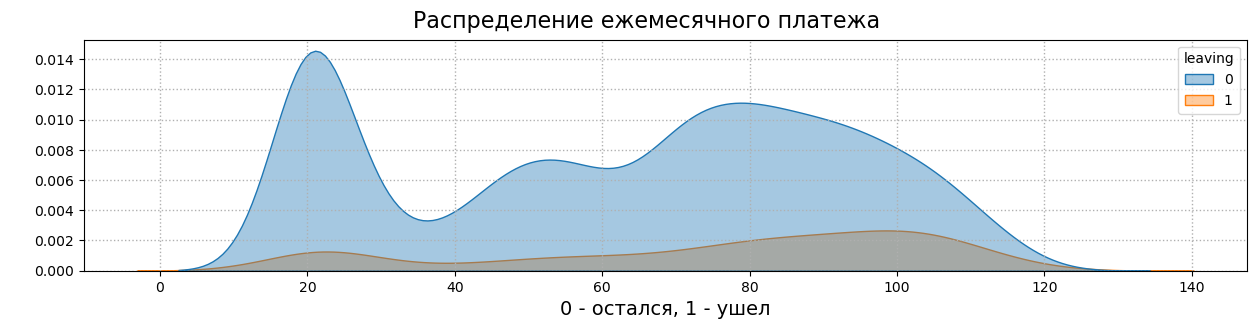

In [42]:
fig, ax = plt.subplots(figsize=(15,3))
fig.suptitle('Распределение ежемесячного платежа', fontsize=16)
kdeplot_t = sns.kdeplot(data['monthly_charges'], alpha=.4, shade=True, label=' ', hue=data['leaving']) 
kdeplot_t.grid(linewidth = 1, linestyle=':')
kdeplot_t.set_xlabel(xlabel='0 - остался, 1 - ушел', fontsize=14)
kdeplot_t.set_ylabel(ylabel=' ', fontsize=14)

plt.show()

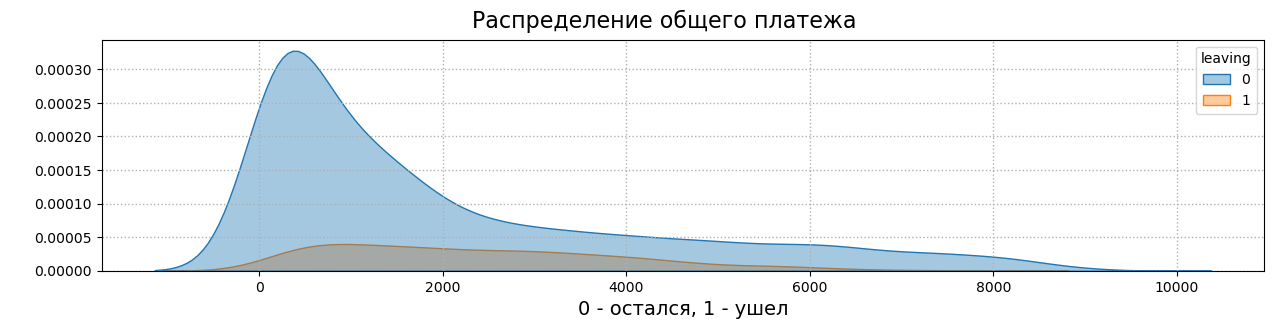

In [43]:
fig, ax = plt.subplots(figsize=(15,3))
fig.suptitle('Распределение общего платежа', fontsize=16)
kdeplot_t = sns.kdeplot(data['total_charges'], alpha=.4, shade=True, label=' ', hue=data['leaving']) 
kdeplot_t.grid(linewidth = 1, linestyle=':')
kdeplot_t.set_xlabel(xlabel='0 - остался, 1 - ушел', fontsize=14)
kdeplot_t.set_ylabel(ylabel=' ', fontsize=14)

plt.show()

По распределению месячного и общего платежей можно сделать вывод о том, что ушедшие клиенты платили заметно больше.

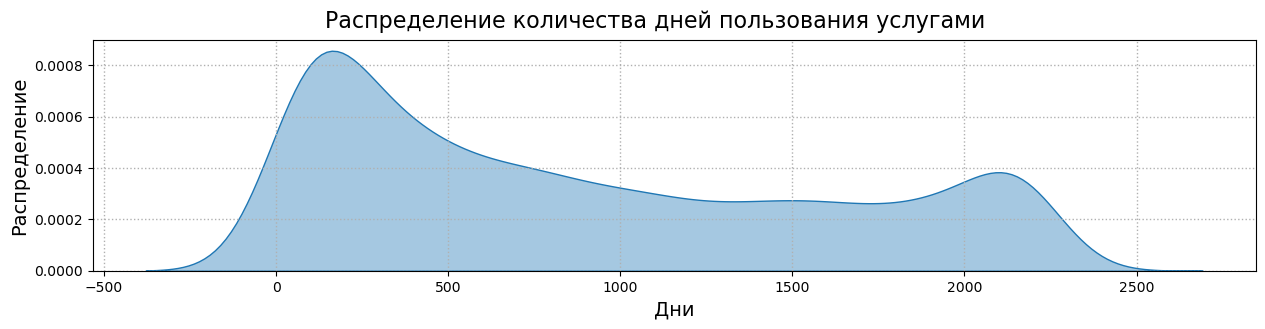

In [44]:
fig, ax = plt.subplots(figsize=(15,3))
fig.suptitle('Распределение количества дней пользования услугами', fontsize=16)
kdeplot_t = sns.kdeplot(data.loc[data['leaving']==0]['days'], alpha=.4, shade=True, label=' ') 
kdeplot_t.grid(linewidth = 1, linestyle=':')
kdeplot_t.set_xlabel(xlabel='Дни', fontsize=14)
kdeplot_t.set_ylabel(ylabel='Распределение', fontsize=14)

plt.show()

Пик распределения приходится примерно на 200 дней. В среднем количество дней пользования услугами варьируется от 0 до 2500.

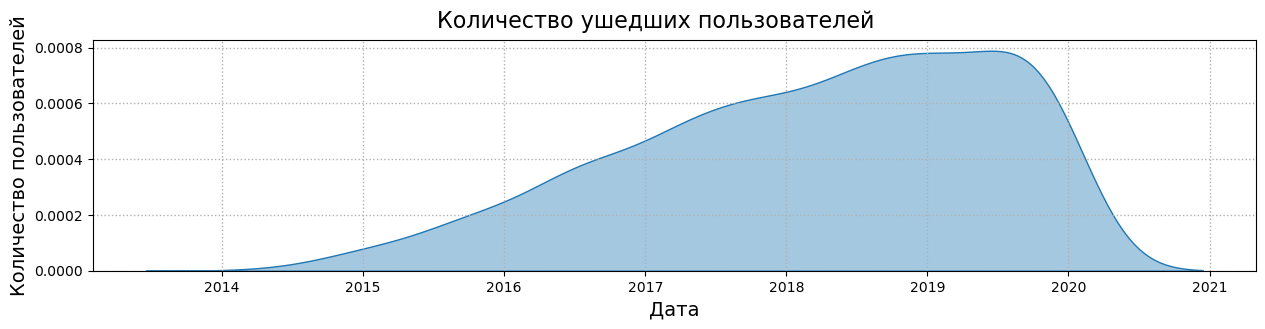

In [45]:
fig, ax = plt.subplots(figsize=(15,3))
fig.suptitle('Количество ушедших пользователей', fontsize=16)
kdeplot_t = sns.kdeplot(((data.loc[data['leaving'] == 1]['end_date']).sort_index(ascending=True)), alpha=.4, shade=True, label=' ') 
kdeplot_t.grid(linewidth = 1, linestyle=':')
kdeplot_t.set_xlabel(xlabel='Дата', fontsize=14)
kdeplot_t.set_ylabel(ylabel='Количество пользователей', fontsize=14)

plt.show()

Пик ухода пользователей приходится с 2019 года.

In [46]:
new_data = data[['leaving',
                 'ustomer_i_d',
                 'type']].groupby(by=['leaving', 'type']).count().sort_values(by=['leaving',
                                                                          'ustomer_i_d'], ascending=False).reset_index()
new_data

,leaving,type,ustomer_i_d
0,1,Month-to-month,407
1,1,Two year,381
2,1,One year,313
3,0,Month-to-month,3468
4,0,Two year,1314
5,0,One year,1160


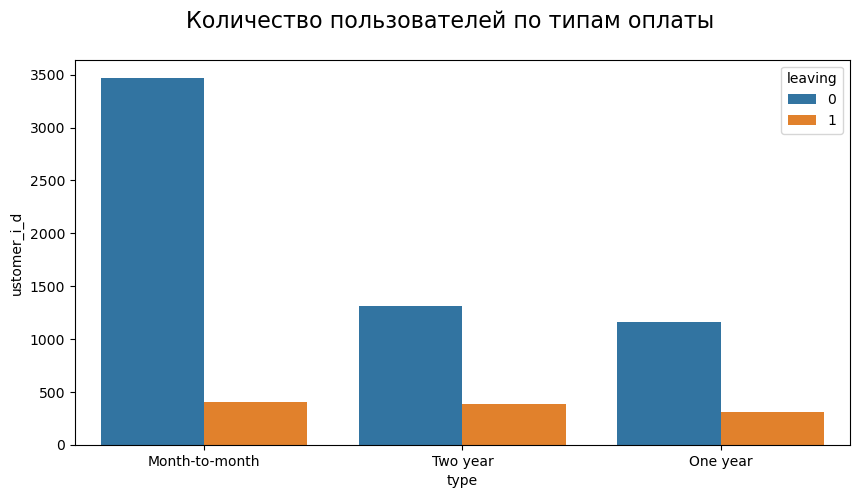

In [47]:
fig, ax = plt.subplots(figsize=(10,5))
fig.suptitle('Количество пользователей по типам оплаты', fontsize=16)
sns.barplot(data=new_data, x='type', y='ustomer_i_d', hue='leaving');

In [48]:
new_data_1 = data[['leaving',
      'ustomer_i_d',
      'payment_method']].groupby(by=['leaving', 'payment_method']).count().sort_values(by=['leaving',
                                                                       'ustomer_i_d'], ascending=False).reset_index()
new_data_1

,leaving,payment_method,ustomer_i_d
0,1,Electronic check,350
1,1,Bank transfer (automatic),317
2,1,Credit card (automatic),317
3,1,Mailed check,117
4,0,Electronic check,2015
5,0,Mailed check,1495
6,0,Bank transfer (automatic),1227
7,0,Credit card (automatic),1205


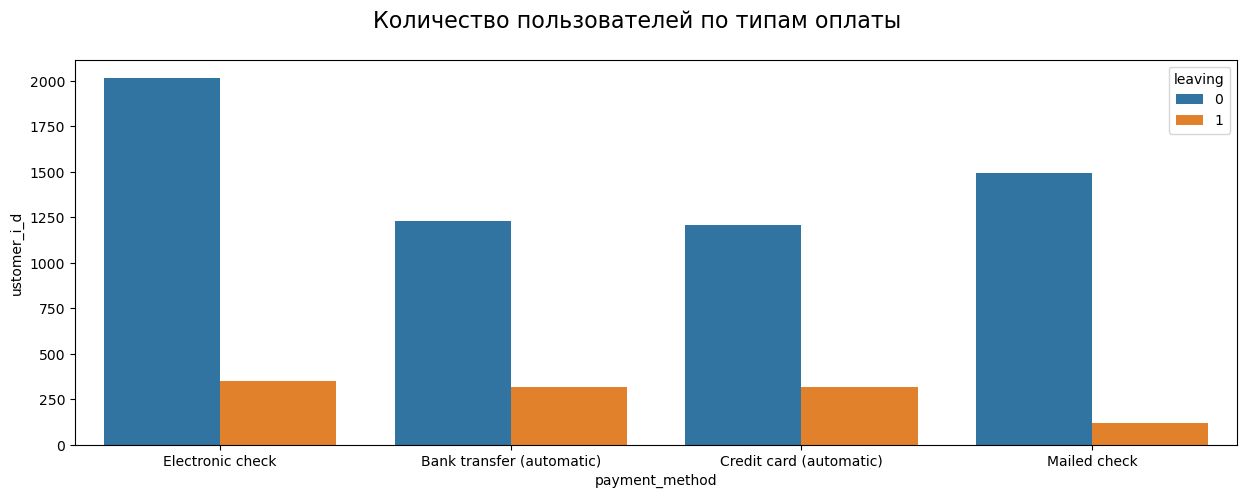

In [49]:
fig, ax = plt.subplots(figsize=(15,5))
fig.suptitle('Количество пользователей по типам оплаты', fontsize=16)
sns.barplot(data=new_data_1, x='payment_method', y='ustomer_i_d', hue='leaving');

Тип и способ оплаты не влияют на уход пользователя - все ушедшие в равной степени пользовались различными методами.

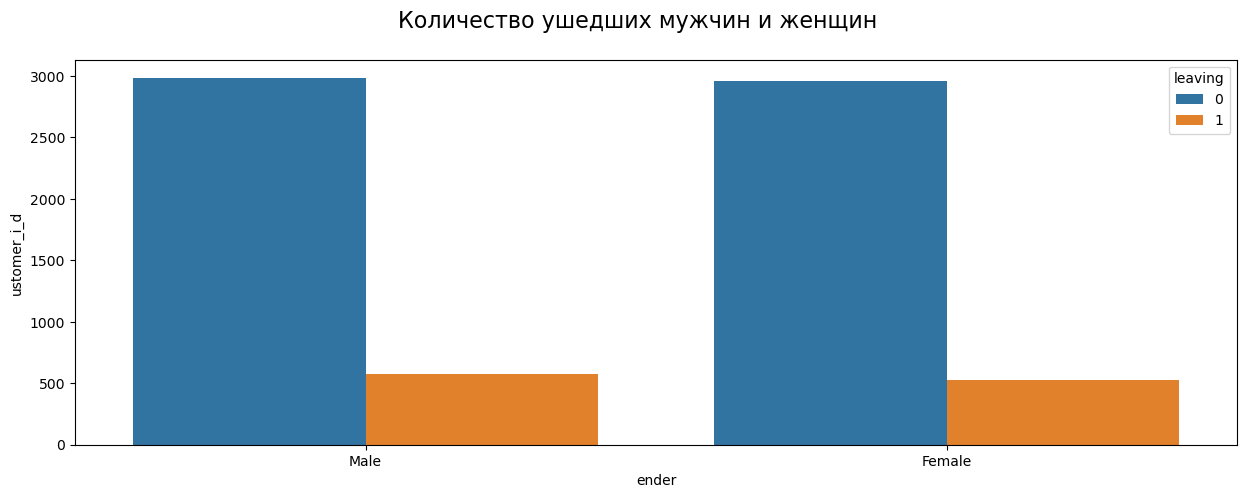

In [50]:
new_data_2 = data[['leaving',
      'ustomer_i_d',
      'ender']].groupby(by=['leaving', 'ender']).count().sort_values(by=['leaving',
                                                                       'ustomer_i_d'], ascending=False).reset_index()

fig, ax = plt.subplots(figsize=(15,5))
fig.suptitle('Количество ушедших мужчин и женщин', fontsize=16)
sns.barplot(data=new_data_2, x='ender', y='ustomer_i_d', hue='leaving');

Количество ушедших мужчин и женщин наравне

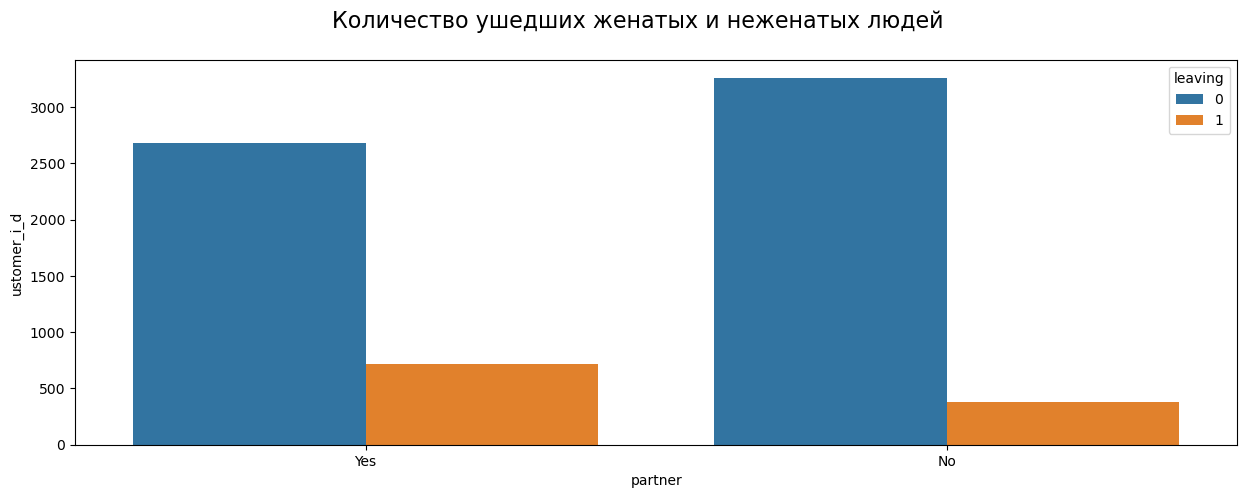

In [51]:
new_data_3 = data[['leaving',
      'ustomer_i_d',
      'partner']].groupby(by=['leaving', 'partner']).count().sort_values(by=['leaving',
                                                                       'ustomer_i_d'], ascending=False).reset_index()

fig, ax = plt.subplots(figsize=(15,5))
fig.suptitle('Количество ушедших женатых и неженатых людей', fontsize=16)
sns.barplot(data=new_data_3, x='partner', y='ustomer_i_d', hue='leaving');

Здесь можем сказать, что ушедших женатых чуть больше, чем неженатых.

In [52]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 22 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   ustomer_i_d        7043 non-null   object        
 1   begin_date         7043 non-null   datetime64[ns]
 2   end_date           7043 non-null   datetime64[ns]
 3   type               7043 non-null   object        
 4   paperless_billing  7043 non-null   object        
 5   payment_method     7043 non-null   object        
 6   monthly_charges    7043 non-null   float64       
 7   total_charges      7043 non-null   float64       
 8   ender              7043 non-null   object        
 9   senior_citizen     7043 non-null   int64         
 10  partner            7043 non-null   object        
 11  dependents         7043 non-null   object        
 12  internet_service   7043 non-null   object        
 13  online_security    7043 non-null   object        
 14  online_b

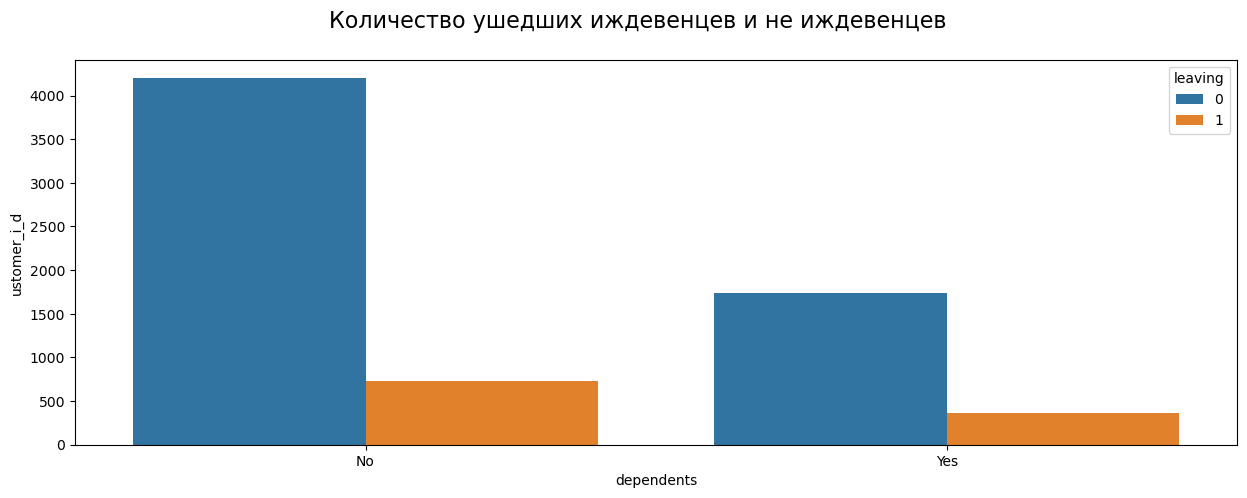

In [53]:
new_data_4 = data[['leaving',
      'ustomer_i_d',
      'dependents']].groupby(by=['leaving', 'dependents']).count().sort_values(by=['leaving',
                                                                       'ustomer_i_d'], ascending=False).reset_index()

fig, ax = plt.subplots(figsize=(15,5))
fig.suptitle('Количество ушедших иждевенцев и не иждевенцев', fontsize=16)
sns.barplot(data=new_data_4, x='dependents', y='ustomer_i_d', hue='leaving');

Ушедших иждевенцев чуть меньше, чем не иждевенцев.

Рассмотрим корреляцию признаков

In [54]:
phik_overview = data.phik_matrix()
phik_overview.round(2)

interval columns not set, guessing: ['monthly_charges', 'total_charges', 'senior_citizen', 'days', 'leaving']


,ustomer_i_d,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,ender,senior_citizen,...,internet_service,online_security,online_backup,device_protection,tech_support,streaming_t_v,streaming_movies,multiple_lines,days,leaving
ustomer_i_d,1.0,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,...,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00
begin_date,1.0,1.00,0.55,0.77,0.08,0.46,0.42,0.77,0.01,0.05,...,0.19,0.46,0.50,0.50,0.46,0.42,0.43,0.47,0.98,0.45
end_date,1.0,0.55,1.00,0.29,0.06,0.17,0.17,0.22,0.02,0.09,...,0.12,0.17,0.24,0.23,0.15,0.19,0.20,0.25,0.40,1.00
type,1.0,0.77,0.29,1.00,0.11,0.28,0.39,0.47,0.00,0.09,...,0.51,0.64,0.58,0.63,0.67,0.55,0.55,0.24,0.63,0.09
paperless_billing,1.0,0.08,0.06,0.11,1.00,0.37,0.47,0.20,0.00,0.24,...,0.23,0.21,0.20,0.20,0.20,0.20,0.20,0.10,0.03,0.08
payment_method,1.0,0.46,0.17,0.28,0.37,1.00,0.40,0.34,0.00,0.29,...,0.32,0.32,0.29,0.30,0.32,0.28,0.29,0.17,0.35,0.21
monthly_charges,1.0,0.42,0.17,0.39,0.47,0.40,1.00,0.71,0.01,0.30,...,0.92,0.81,0.82,0.83,0.82,0.86,0.86,0.71,0.39,0.23
total_charges,1.0,0.77,0.22,0.47,0.20,0.34,0.71,1.00,0.00,0.14,...,0.49,0.52,0.55,0.56,0.53,0.56,0.55,0.47,0.85,0.30
ender,1.0,0.01,0.02,0.00,0.00,0.00,0.01,0.00,1.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.01
senior_citizen,1.0,0.05,0.09,0.09,0.24,0.29,0.30,0.14,0.00,1.00,...,0.16,0.13,0.11,0.11,0.14,0.11,0.11,0.09,0.06,0.09


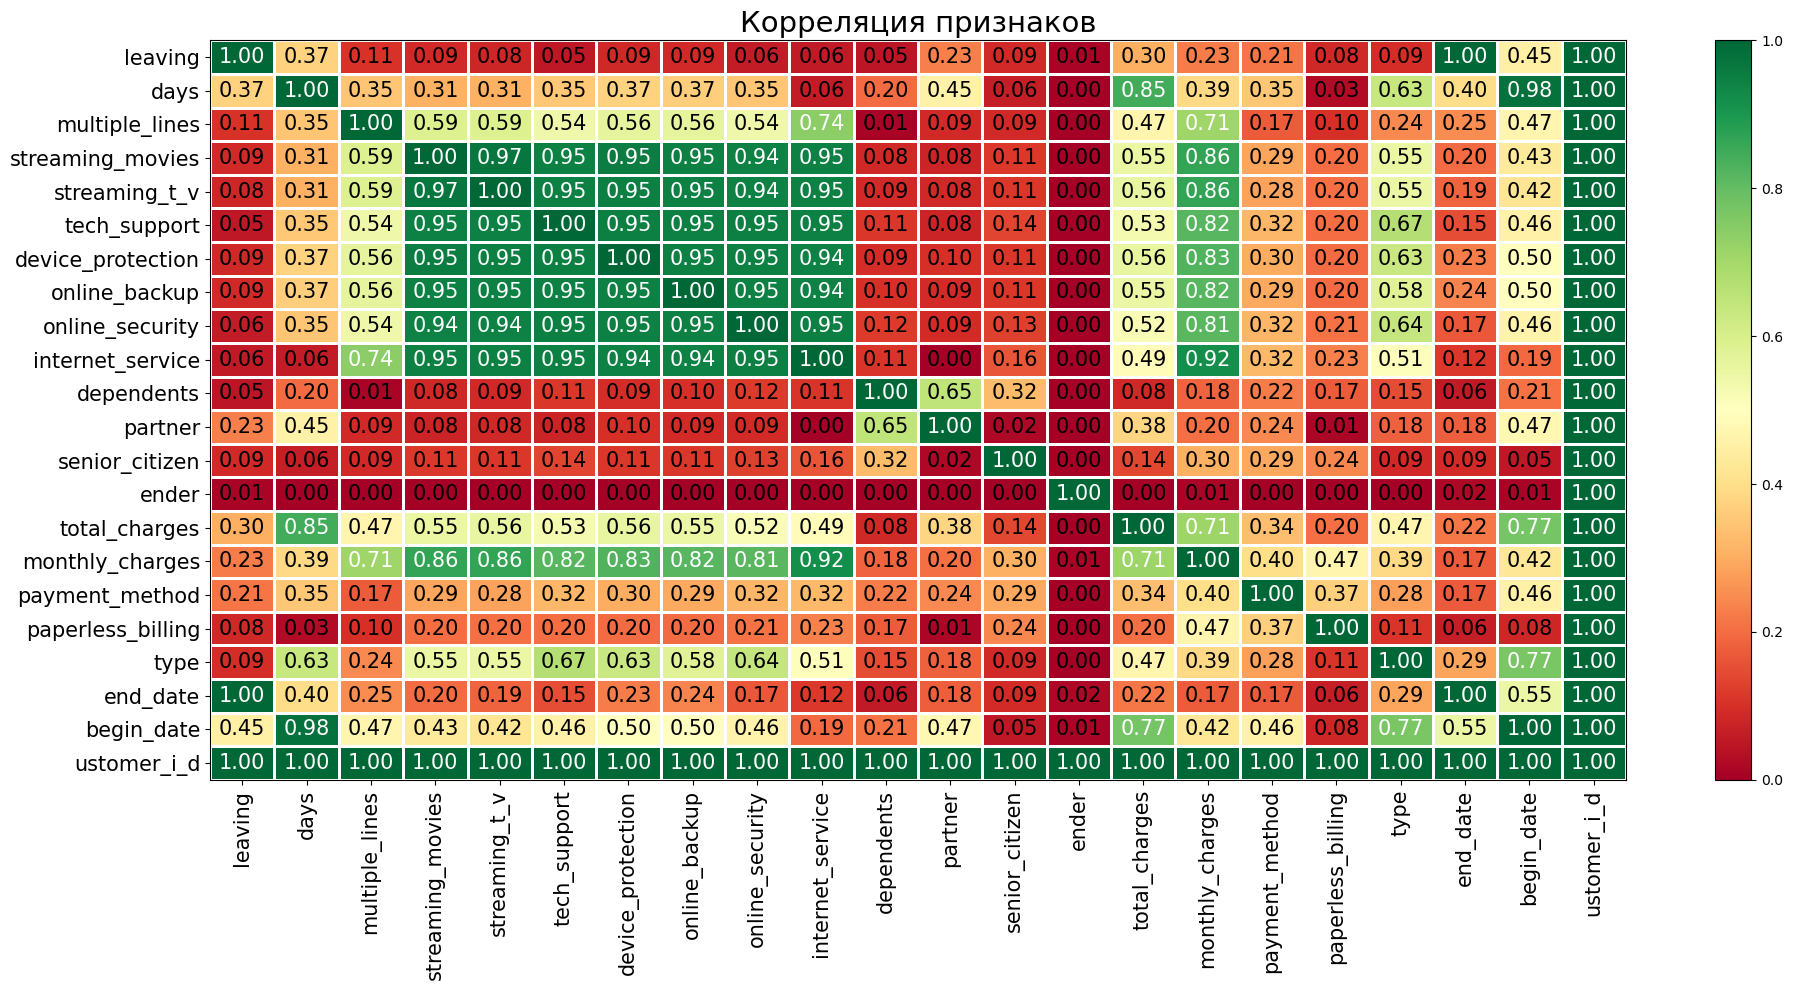

In [55]:
plot_correlation_matrix(phik_overview.values, 
                        x_labels=phik_overview.columns, 
                        y_labels=phik_overview.index, 
                        vmin=0, vmax=1,  
                        title='Корреляция признаков', 
                        fontsize_factor=1.5, 
                        figsize=(20, 10))
plt.tight_layout()

 Видим зависимость между различными услугами (`streaming_movies`, `streaming_tv` и т.д.) и месячными платежами `monthly_charges`. Также сгенерированный признак `days` зависим от `total_charges` и `begin_date`. 

**Вывод**

Таким образом, был проведен анализ, в ходе которого мы выяснили:

- Ушедшие пользователи платили больше
- Пик пользования услугами приходится на 200 дней
- В 2019 году ушло больше всего клиентов

## Обучение модели

В данном разделе необходимо разобить выборку 75% на 25%, закодировать категориальные признаки, выделить целевой признак, удалить ненужные столбцы, проверить баланс классов и масштаб признаков.

In [56]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 22 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   ustomer_i_d        7043 non-null   object        
 1   begin_date         7043 non-null   datetime64[ns]
 2   end_date           7043 non-null   datetime64[ns]
 3   type               7043 non-null   object        
 4   paperless_billing  7043 non-null   object        
 5   payment_method     7043 non-null   object        
 6   monthly_charges    7043 non-null   float64       
 7   total_charges      7043 non-null   float64       
 8   ender              7043 non-null   object        
 9   senior_citizen     7043 non-null   int64         
 10  partner            7043 non-null   object        
 11  dependents         7043 non-null   object        
 12  internet_service   7043 non-null   object        
 13  online_security    7043 non-null   object        
 14  online_b

Разделим выборку на признаки и целевой признак

In [57]:
target = data['leaving']

features = data.drop(['leaving', 'ustomer_i_d', 'begin_date', 'end_date', 
                          'multiple_lines', 'paperless_billing', 'device_protection',
                         'online_security', 'online_backup', 'device_protection', 
                          'dependents', 'multiple_lines', 'ender'], axis=1)

In [58]:
print('Размер признаков:', features.shape)
print('Размер целевого признака:', target.shape)

Размер признаков: (7043, 11)
Размер целевого признака: (7043,)


Разделим данные на тренировочную и тестовую выборки в соотношении 3 к 1

In [59]:
features_train, features_test, target_train, target_test = train_test_split(features, target, test_size=.25, random_state=170723)

In [60]:
print('Размер тренировочной выборки признаков:', features_train.shape, 
          'Тренировочной целевого признака:', target_train.shape, sep='\n')
print('Размер тестовой выборки признаков:', features_test.shape, 
          'Тестовой целевого признака:', target_test.shape, sep='\n')

Размер тренировочной выборки признаков:
(5282, 11)
Тренировочной целевого признака:
(5282,)
Размер тестовой выборки признаков:
(1761, 11)
Тестовой целевого признака:
(1761,)


In [61]:
pd.concat([target_train.value_counts(), target_test.value_counts()], axis=1)

,leaving,leaving
0,4468,1474
1,814,287


Для дальнейшего кодирования необходимо выделить категориальные признаки

In [62]:
categorial = features_train.select_dtypes(include='object').columns.to_list()
categorial

['type',
 'payment_method',
 'partner',
 'internet_service',
 'tech_support',
 'streaming_t_v',
 'streaming_movies']

Закодируем признаки с помощью OneHotEncoder

In [63]:
encoder_ohe = OneHotEncoder(drop='first', sparse=False)
encoder_ohe.fit(features_train[categorial])
features_train[encoder_ohe.get_feature_names()] = encoder_ohe.transform(features_train[categorial])
features_train = features_train.drop(categorial, axis=1)
features_train

,monthly_charges,total_charges,senior_citizen,days,x0_One year,x0_Two year,x1_Credit card (automatic),x1_Electronic check,x1_Mailed check,x2_Yes,x3_Fiber optic,x3_no,x4_Yes,x4_no,x5_Yes,x5_no,x6_Yes,x6_no
5971,20.00,1412.40,0,2010,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0
1711,24.40,1749.72,0,2163,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0
6368,94.00,564.00,1,184,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
6659,92.30,7044.34,0,2191,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
1276,99.40,7057.40,1,2163,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3733,35.05,893.77,0,761,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
744,44.05,220.25,0,153,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6166,104.20,3792.88,0,1067,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
2636,113.00,8542.80,1,2132,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0


Обученым тренировочным энкодером закодируем тестовую выборку

In [64]:
features_test[encoder_ohe.get_feature_names()] = encoder_ohe.transform(features_test[categorial])
features_test = features_test.drop(categorial, axis=1)

Создадим функцию которая:

- строит pipeline с стандартизацией и моделью;
- с помощью RandomizedSearchCV подбирает лучшие гиперпараметры, возвращает модель, лучшую оценку ROC-AUC.

In [65]:
def check_model(model, params, features=features_train, 
              target=target_train):
    
    scaler = StandardScaler()
    pipe = Pipeline(steps=[('scaler', scaler), ('model', model)])

    RSCV = RandomizedSearchCV(estimator=pipe, param_distributions=params, 
                              cv=5, n_jobs=-1, scoring='roc_auc', random_state=170723)

    RSCV.fit(features, target)

    best_estimator = RSCV.best_estimator_
    best_score = RSCV.best_score_
    print('Модель с лучшими гиперпараметрами:')
    print(best_estimator)
    print('ROC-AUC на тренировочной выборке: {:.5f}'.format(best_score))

    return best_estimator

### Logistic Regression

Создадим пул для перебора параметров

In [66]:
model_lr_params = {'model__C': [1, 2, 3, 5], 
                  'model__class_weight': [None, 'balanced'],
                  'model__fit_intercept': [True, False],
                  'model__l1_ratio': [None],
                  'model__max_iter': [100, 200, 70],
                  'model__n_jobs': [-1],
                  'model__penalty': ['l2'],
                  'model__random_state': [170723],
                  'model__solver': ['lbfgs', 'newton-cg', 'lbfgs', 'sag', 'saga'],
                  'model__tol': [0.0001, 0.001],}

In [67]:
model_lr = LogisticRegression()

In [68]:
model_lr = check_model(model_lr, model_lr_params)

Модель с лучшими гиперпараметрами:
Pipeline(steps=[('scaler', StandardScaler()),
                ('model',
                 LogisticRegression(C=3, max_iter=70, n_jobs=-1,
                                    random_state=170723, solver='sag'))])
ROC-AUC на тренировочной выборке: 0.74322


### CatBoost

In [69]:
cat = CatBoostClassifier()

In [70]:
cat_param = {'model__random_state': [170723], 'model__iterations': [500], 
             'model__depth': [3, 5, 7, 10], 'model__learning_rate': [.1, .01, .5], 
             'model__l2_leaf_reg': [1, 3, 5, 10], 'model__loss_function': ['Logloss', 'CrossEntropy'],
            'model__eval_metric': ['AUC'],}

In [71]:
model_cat = check_model(cat, cat_param)

0:	total: 177ms	remaining: 1m 28s
1:	total: 181ms	remaining: 45s
2:	total: 185ms	remaining: 30.6s
3:	total: 189ms	remaining: 23.4s
4:	total: 193ms	remaining: 19.1s
5:	total: 197ms	remaining: 16.2s
6:	total: 201ms	remaining: 14.2s
7:	total: 205ms	remaining: 12.6s
8:	total: 208ms	remaining: 11.4s
9:	total: 212ms	remaining: 10.4s
10:	total: 215ms	remaining: 9.58s
11:	total: 219ms	remaining: 8.92s
12:	total: 223ms	remaining: 8.36s
13:	total: 227ms	remaining: 7.87s
14:	total: 230ms	remaining: 7.45s
15:	total: 234ms	remaining: 7.08s
16:	total: 238ms	remaining: 6.76s
17:	total: 241ms	remaining: 6.46s
18:	total: 245ms	remaining: 6.21s
19:	total: 249ms	remaining: 5.97s
20:	total: 253ms	remaining: 5.76s
21:	total: 257ms	remaining: 5.58s
22:	total: 260ms	remaining: 5.4s
23:	total: 264ms	remaining: 5.23s
24:	total: 268ms	remaining: 5.09s
25:	total: 271ms	remaining: 4.95s
26:	total: 275ms	remaining: 4.82s
27:	total: 279ms	remaining: 4.71s
28:	total: 283ms	remaining: 4.6s
29:	total: 288ms	remaining:

### LGBM

In [72]:
lgbm = lgb.LGBMClassifier()

In [73]:
lgbm_param = {'model__boosting_type': ['gbdt', 'dart', 'goss'], 
                    'model__class_weight': [None, 'balanced'], 
                    'model__importance_type': ['split', 'gain'], 
                    'model__learning_rate': [0.1, 0.05, 0.3, 0.01, 0.6], 
                    'model__max_depth': [-1, 3, 5, 6], 
                    'model__n_estimators': [50, 100, 150, 500, 1000], 
                    'model__n_jobs': [-1], 
                    'model__random_state': [170723], 
                    'model__subsample_for_bin': [200000, 50000, 100000]}

In [74]:
lgbm_model = check_model(lgbm, lgbm_param)

Модель с лучшими гиперпараметрами:
Pipeline(steps=[('scaler', StandardScaler()),
                ('model',
                 LGBMClassifier(class_weight='balanced', learning_rate=0.3,
                                max_depth=3, n_estimators=500,
                                random_state=170723))])
ROC-AUC на тренировочной выборке: 0.88256


**Вывод**

Обучено три модели. Лучшей оказалась CatBoostClassifier со значением ROC-AUC 0,91

Далее проверим лучшую модель на тестовой выборке.

Создадим такой же метод, в котором в добавок построим AUC-ROC кривую.

CatBoost: ROC AUC=0.940


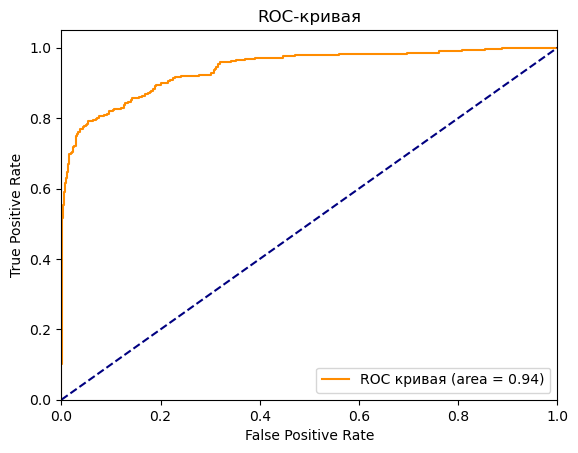

In [75]:
pred_test = model_cat.predict(features_test)
lr_probs = model_cat.predict_proba(features_test)
lr_probs = lr_probs[:, 1]
lr_auc = roc_auc_score(target_test, lr_probs)
print('CatBoost: ROC AUC=%.3f' % (lr_auc))
fpr, tpr, treshold = roc_curve(target_test, lr_probs)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, color='darkorange',label='ROC кривая (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')
plt.legend(loc="lower right")
plt.show()

Text(50.722222222222214, 0.5, 'Истинный класс')

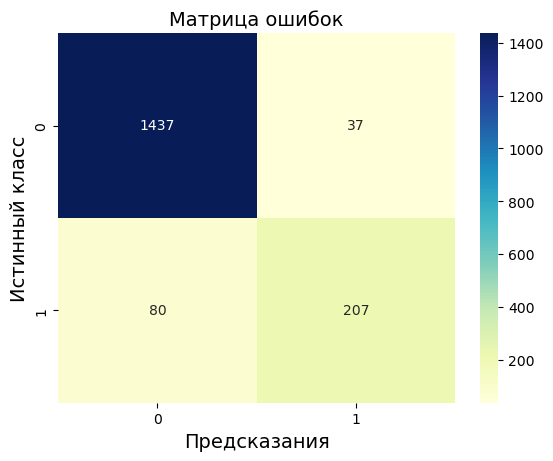

In [76]:
heatmap_1 = sns.heatmap((confusion_matrix(target_test, pred_test)), cmap="YlGnBu", 
                            annot=True, fmt='d')
    
heatmap_1.set_title('Матрица ошибок', fontdict={'fontsize':14})
heatmap_1.set_xlabel('Предсказания', fontsize=14)
heatmap_1.set_ylabel('Истинный класс', fontsize=14)

207 истинноположительных предсказаний (из 287 класса 1) и всего 37 ложноположительных, 80 ложноотрицательных предсказаний. 

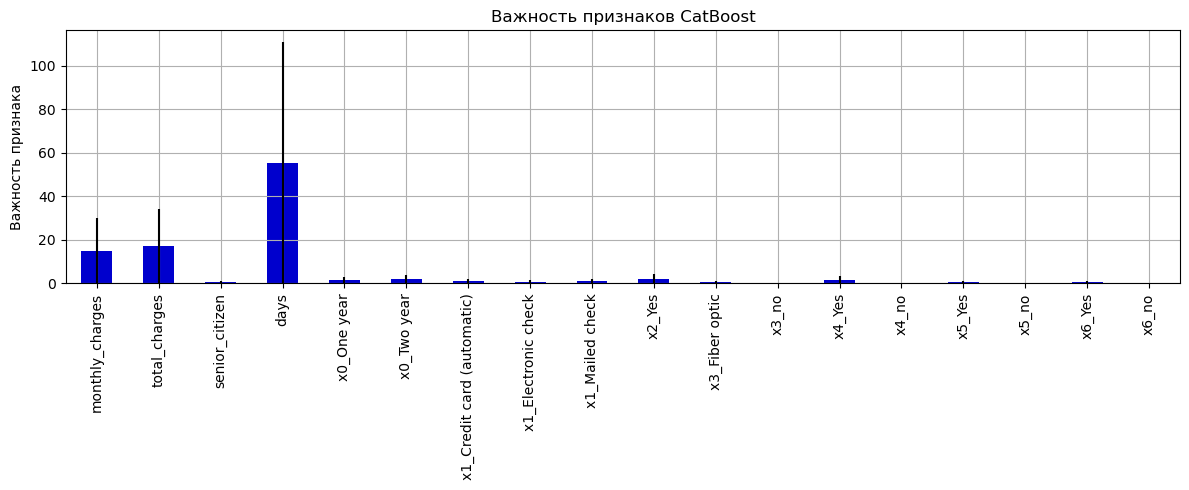

In [77]:
feature_importance_cat = model_cat[1].get_feature_importance()
feature_importance_cat = pd.Series(feature_importance_cat, index=features_test.columns)
fig, ax = plt.subplots(figsize=(12, 5))
feature_importance_cat.plot.bar(yerr=feature_importance_cat, ax=ax, color='mediumblue', grid=True)
ax.set_title("Важность признаков CatBoost")
ax.set_ylabel('Важность признака')
fig.tight_layout()

In [78]:
model_cat.get_params()

{'memory': None,
 'steps': [('scaler', StandardScaler()),
  ('model', <catboost.core.CatBoostClassifier at 0x1ea2c2ce580>)],
 'verbose': False,
 'scaler': StandardScaler(),
 'model': <catboost.core.CatBoostClassifier at 0x1ea2c2ce580>,
 'scaler__copy': True,
 'scaler__with_mean': True,
 'scaler__with_std': True,
 'model__iterations': 500,
 'model__learning_rate': 0.5,
 'model__depth': 3,
 'model__l2_leaf_reg': 1,
 'model__loss_function': 'CrossEntropy',
 'model__eval_metric': 'AUC',
 'model__random_state': 170723}

Наиболее важными признаками для CatBoostClassifier оказались: `days`, `monthly_charges` и `total_charges`.

## Вывод

В данном проекте было необходимо создать модель, предсказывающую уход клиента. Оценивали модель метрикой AUC-ROC.

В работу поступило 4 датасета с информацией о датах заключения контракта, дате разрыва контракта, сумм затрат на ежемесячные платежи и общих сумм затрат клиента, персональной информации о клиентах, сведения об услугах интрернета, телефонии.

Исходные 4 датасета были объединены в одну таблицу.
Далее была проведена работа по избавлению от пропусков. Также были добавлены новые столбцы: целевой признак `leaving` и `days` - количество дней с даты регистрации. По сформированному датасету был проведён исследовательский анализ данных, в ходе которого было выявлено:

- Ушедшие клиенты компании платили больше других
- Большое количество людей задерживаются в компании не больше 200 дней.
- Большинство пользователей ушли из компании в 2019 году.
- В пользовании различными услугами, а также в поле и семейном статусе закономерностей найти не удалось.
- При исследовании корреляции признаков подтвердилось, что месячный платеж зависит от общего платежа, также общий платеж зависит от количества дней пользования.

Далее были закодированы категориальные признаки, выделен целевой признак, разделены выборки. Создана функция, стандартизирующая модель и находящая лучшие параметры с помощью RandomizeSearchCV.
Первая модель была выбрана LogisticRegression(ROC-AUC = 0,74), CatBoostClassifier(ROC-AUC = 0,91), LGBMClassifier(ROC-AUC = 0,88).

Лучшая модель CatBoostClassifier была проверена на тестовой выборке (ROC-AUC = 0,94). Модель предсказала 72% истинноположительных ответов, всего 37 ложноположительных и 80 ложноотрицательных предсказаний. Самым важным признаком для данной модели оказался `days` - количество дней пользования услугами.